## Combine ASR, Consensus, and eUniRep designs into one dataframe for downstream analysis and to order DNA from Twist

In [1]:
import os
import sys
import pickle

from Bio.Seq import translate, reverse_complement
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.decomposition import PCA


sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils

sys.path.append('../A006_simulated_annealing/')
import A006_common

sys.path.append('../A003_policy_optimization/')
import A003_common

import A009_common

%reload_ext autoreload
%autoreload 2

In [2]:
designed_df = pd.read_csv('./GFP_Chip_1_interesting_variants_to_individually_test.csv')
asr_df = pd.read_csv('./GFP_FastML_N1_N11_ASR_seqs.csv') 
con_df = pd.read_csv('./GFP_consensus_seqs.csv')

display(designed_df.head())
display(asr_df.head())
display(con_df.head())

,id,qfunc,qfunc_rep1,qfunc_rep2,extracted_lib_nt_seq,seq_idx,trajectory_idx,predicted_fitness,ensemble_predicted_fitness,seq,...,DE_Chip_1_GFP_NGS_16,DE_Chip_1_GFP_NGS_17,DE_Chip_1_GFP_NGS_18,model,ntrain,rep,rep_hash,seq_traj_idx,special_case,reason_to_keep
0,GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278...,2.084822,4.035561,3.991303,AAAGGCGAGGGTGAAGGTGACGCAACTTATGGTAAACTGACGATGA...,741.0,757.0,0.806349,[0.6696898 0.8881707 0.8819387 0.77494574 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGKLTMKF...,...,42643.0,15152.0,2.0,ET_Global_Init_2,24.0,2.0,f795278,seq_idx_741_757,NaN,super bright
1,GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e...,2.178010,4.164580,4.048660,AAAGGCGAGGGTGAAGGTGACGCAACTTATGGTAAACTGACGCTGA...,250.0,1567.0,0.934624,[1.0833814 0.9712182 1.030976 1.0560803 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGKLTLKF...,...,62434.0,5376.0,2.0,ET_Global_Init_1,96.0,0.0,3ea5f6e,seq_idx_250_1567,NaN,super bright
2,GFP_SimAnneal-ET_Global_Init_2-0024-01-25f01ed...,2.235970,4.164580,4.164580,AGCGGCGAGGGTATAGGTGACGCAACTTATGGTAAACTGACGCTGA...,250.0,1204.0,1.031569,[1.1073396 0.93092555 1.0252638 1.107651 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGIGDATYGKLTLKF...,...,16334.0,5326.0,0.0,ET_Global_Init_2,24.0,1.0,25f01ed8,seq_idx_250_1204,NaN,super bright
3,GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278...,2.061235,4.005058,3.974633,AGCGGCGAGGGTCAAGGTGACGCAACTTATGGTAAAATTAATATGA...,827.0,1609.0,0.737398,[0.633723 0.7840624 0.8353076 0.71499825 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGQGDATYGKINMKF...,...,41722.0,21210.0,2.0,ET_Global_Init_2,24.0,2.0,f795278,seq_idx_827_1609,NaN,super bright
4,GFP_SimAnneal-ET_Global_Init_1-0024-01-3a0e3d4...,2.186547,4.164580,4.065734,AGCGGCGAGGGTGAAGGTGACGCAACTATAGGTAAACTGACGCTGA...,372.0,512.0,0.890756,[1.0049036 0.8029096 1.0446074 0.7925129 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATIGKLTLKF...,...,72073.0,27172.0,1.0,ET_Global_Init_1,24.0,1.0,3a0e3d4,seq_idx_372_512,NaN,super bright


,id,seq
0,N1_8_-9.972933__N11_8_-7.828874,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
1,N1_10_-10.890914__N11_2_-2.499699,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,N1_9_-10.323871,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,N1_1_-0.006831__N11_3_-2.629019,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,N1_4_-6.833884__N11_1_-0.180372,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


,id,seq,log_likelihood
0,top_consensus_seq,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,-12.190691
1,sampled_consensus_seq_1,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,-12.190691
2,sampled_consensus_seq_2,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,-12.304020
3,sampled_consensus_seq_3,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,-12.304020
4,sampled_consensus_seq_4,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,-12.500846


45 + 25 + 16 + 50 = 136 possible sequences to test. Let's get it down to 96.

We probably only need 20 consensus sequences and 35 super bright candidates, instead of 50 and 45 respectively. This brings it down to 96.

In [3]:
bright_designed_df = designed_df[designed_df['reason_to_keep'] == 'super bright']
bright_designed_df.sort_values('qfunc', ascending=False, inplace=True)

# Keep one more bright sequence than intended as there is one sequence
# that is in both the bright and far but better than WT set.
final_bright_designed_df = bright_designed_df.iloc[:35+1]

print(final_bright_designed_df.shape)
display(final_bright_designed_df.head())
display(final_bright_designed_df.tail())

(36, 46)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,qfunc,qfunc_rep1,qfunc_rep2,extracted_lib_nt_seq,seq_idx,trajectory_idx,predicted_fitness,ensemble_predicted_fitness,seq,...,DE_Chip_1_GFP_NGS_16,DE_Chip_1_GFP_NGS_17,DE_Chip_1_GFP_NGS_18,model,ntrain,rep,rep_hash,seq_traj_idx,special_case,reason_to_keep
33,GFP_SimAnneal-ET_Random_Init_1-0024-02-1d0c486...,2.366857,4.298262,4.292672,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTTGCCTGACGCTGA...,250.0,906.0,0.756440,[0.83942366 0.86589384 0.8249143 0.6884651 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...,...,51966.0,206016.0,3.0,ET_Random_Init_1,24.0,2.0,1d0c4863,seq_idx_250_906,NaN,super bright
28,GFP_SimAnneal-ET_Global_Init_1-0096-02-341cf5c...,2.308773,4.310188,4.164580,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTAAACTGACGCTGA...,261.0,2855.0,0.799948,[0.6417749 0.98740137 0.79837656 0.80319446 1...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,59785.0,24932.0,5.0,ET_Global_Init_1,96.0,2.0,341cf5c,seq_idx_261_2855,NaN,super bright
24,GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278...,2.289023,4.164580,4.270686,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTAAACTGACGCTGA...,589.0,1867.0,0.777800,[0.65868104 0.83154964 0.8774681 0.7318897 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,82729.0,109693.0,9.0,ET_Global_Init_2,24.0,2.0,f795278,seq_idx_589_1867,NaN,super bright
15,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,2.235970,4.164580,4.164580,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTAAACTGACGCTGA...,250.0,57.0,0.730526,[0.6237304 0.6926489 0.8283763 0.5250895 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,83271.0,24123.0,16.0,ET_Global_Init_1,24.0,2.0,31e54146,seq_idx_250_57,NaN,super bright
21,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,2.235970,4.164580,4.164580,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTAAACTGACGCTGA...,250.0,307.0,0.729753,[0.62313056 0.7041776 0.8224685 0.5251329 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,65376.0,18596.0,3.0,ET_Global_Init_1,24.0,2.0,31e54146,seq_idx_250_307,NaN,super bright


,id,qfunc,qfunc_rep1,qfunc_rep2,extracted_lib_nt_seq,seq_idx,trajectory_idx,predicted_fitness,ensemble_predicted_fitness,seq,...,DE_Chip_1_GFP_NGS_16,DE_Chip_1_GFP_NGS_17,DE_Chip_1_GFP_NGS_18,model,ntrain,rep,rep_hash,seq_traj_idx,special_case,reason_to_keep
3,GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278...,2.061235,4.005058,3.974633,AGCGGCGAGGGTCAAGGTGACGCAACTTATGGTAAAATTAATATGA...,827.0,1609.0,0.737398,[0.633723 0.7840624 0.8353076 0.71499825 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGQGDATYGKINMKF...,...,41722.0,21210.0,2.0,ET_Global_Init_2,24.0,2.0,f795278,seq_idx_827_1609,NaN,super bright
29,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.054807,4.016758,3.950078,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTAAACTGAGCCTGA...,365.0,845.0,0.779704,[0.9852459 0.75262535 0.8024437 1.0285392 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLSLKF...,...,45492.0,6000.0,0.0,ET_Global_Init_1,24.0,4.0,4502d3,seq_idx_365_845,NaN,super bright
41,GFP_SimAnneal-ET_Global_Init_1-0024-01-3a0e3d4...,2.048377,3.962668,3.991306,AGCGGCGAGGGTGTAGGTGACGCAACTTATGGTAAACTGACGCTGA...,486.0,2865.0,0.846218,[1.0826617 0.7409425 1.065856 0.74705577 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGVGDATYGKLTLKF...,...,9151.0,4247.0,0.0,ET_Global_Init_1,24.0,1.0,3a0e3d4,seq_idx_486_2865,NaN,super bright
10,GFP_SimAnneal-ET_Global_Init_1-0096-02-SmallTr...,2.043829,3.999154,3.945725,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTAAAATGACGCTGA...,580.0,2167.0,0.834001,[0.6429958 1.051499 0.81011665 0.8233338 1...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKMTLKF...,...,27055.0,1.0,2.0,ET_Global_Init_1,96.0,2.0,2b7857eb,seq_idx_580_2167,SmallTrust,super bright
11,GFP_SimAnneal-ET_Global_Init_1-0096-00-SmallTr...,2.036767,4.058638,3.872116,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTAAAATTACGCTGA...,817.0,686.0,0.961433,[1.2243631 1.0055023 1.049521 1.0764194 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKITLKF...,...,7858.0,10976.0,0.0,ET_Global_Init_1,96.0,0.0,2e8818d2,seq_idx_817_686,SmallTrust,super bright


In [4]:
# Keep all far but functional
final_far_func_designed_df = designed_df[designed_df['reason_to_keep'] == 'far but better than wt']
print(final_far_func_designed_df.shape)

(25, 46)


In [5]:
final_asr_df = asr_df
print(final_asr_df.shape)

(16, 2)


In [6]:
con_df.sort_values('log_likelihood', ascending=False, inplace=True)

final_con_df = con_df.iloc[:20]
print(final_con_df.shape)

(20, 3)


In [7]:
final_df = pd.concat([final_bright_designed_df, final_far_func_designed_df, final_asr_df, final_con_df], 
                     axis=0, sort=False)

print(final_df.shape)
display(final_df.head())
display(final_df.tail())

(97, 47)


,id,qfunc,qfunc_rep1,qfunc_rep2,extracted_lib_nt_seq,seq_idx,trajectory_idx,predicted_fitness,ensemble_predicted_fitness,seq,...,DE_Chip_1_GFP_NGS_17,DE_Chip_1_GFP_NGS_18,model,ntrain,rep,rep_hash,seq_traj_idx,special_case,reason_to_keep,log_likelihood
33,GFP_SimAnneal-ET_Random_Init_1-0024-02-1d0c486...,2.366857,4.298262,4.292672,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTTGCCTGACGCTGA...,250.0,906.0,0.756440,[0.83942366 0.86589384 0.8249143 0.6884651 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...,...,206016.0,3.0,ET_Random_Init_1,24.0,2.0,1d0c4863,seq_idx_250_906,NaN,super bright,NaN
28,GFP_SimAnneal-ET_Global_Init_1-0096-02-341cf5c...,2.308773,4.310188,4.164580,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTAAACTGACGCTGA...,261.0,2855.0,0.799948,[0.6417749 0.98740137 0.79837656 0.80319446 1...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,24932.0,5.0,ET_Global_Init_1,96.0,2.0,341cf5c,seq_idx_261_2855,NaN,super bright,NaN
24,GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278...,2.289023,4.164580,4.270686,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTAAACTGACGCTGA...,589.0,1867.0,0.777800,[0.65868104 0.83154964 0.8774681 0.7318897 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,109693.0,9.0,ET_Global_Init_2,24.0,2.0,f795278,seq_idx_589_1867,NaN,super bright,NaN
15,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,2.235970,4.164580,4.164580,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTAAACTGACGCTGA...,250.0,57.0,0.730526,[0.6237304 0.6926489 0.8283763 0.5250895 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,24123.0,16.0,ET_Global_Init_1,24.0,2.0,31e54146,seq_idx_250_57,NaN,super bright,NaN
21,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,2.235970,4.164580,4.164580,AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTAAACTGACGCTGA...,250.0,307.0,0.729753,[0.62313056 0.7041776 0.8224685 0.5251329 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,18596.0,3.0,ET_Global_Init_1,24.0,2.0,31e54146,seq_idx_250_307,NaN,super bright,NaN


,id,qfunc,qfunc_rep1,qfunc_rep2,extracted_lib_nt_seq,seq_idx,trajectory_idx,predicted_fitness,ensemble_predicted_fitness,seq,...,DE_Chip_1_GFP_NGS_17,DE_Chip_1_GFP_NGS_18,model,ntrain,rep,rep_hash,seq_traj_idx,special_case,reason_to_keep,log_likelihood
15,sampled_consensus_seq_15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.793568
16,sampled_consensus_seq_16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.922060
17,sampled_consensus_seq_17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.922060
18,sampled_consensus_seq_18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.924660
19,sampled_consensus_seq_19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.924660


In [8]:
print(len(np.unique(final_df['id'])))
print(len(np.unique(final_df['seq'])))

96
96


Sequence GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278-seq_idx_827_1609 is in both the super bright and far-but-better-than-WT sequence set, hence we have 97 seqs listed, but 96 unique.

In [9]:
mask = final_df['id'] == 'GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278-seq_idx_827_1609'
print(utils.levenshtein_distance_matrix(list(final_df[mask]['seq'])))

print(final_df[mask]['reason_to_keep'])

final_df.loc[mask, 'reason_to_keep'] = 'super bright, far but better than wt'

print(final_df[mask]['reason_to_keep'])

[[0. 0.]
 [0. 0.]]
3               super bright
48    far but better than wt
Name: reason_to_keep, dtype: object
3     super bright, far but better than wt
48    super bright, far but better than wt
Name: reason_to_keep, dtype: object


Unique-ify

In [10]:
final_df.drop_duplicates(subset='id', keep='first', inplace=True)

print(final_df.shape)

final_df[final_df['id'] == 'GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278-seq_idx_827_1609']['reason_to_keep']

(96, 47)


3    super bright, far but better than wt
Name: reason_to_keep, dtype: object

In [11]:
simple_final_df = pd.DataFrame()
simple_final_df['id'] = final_df['id']
simple_final_df['seq'] = final_df['seq']

annotations = []
for i,r in simple_final_df.iterrows():
    annot = ''
    
    if r['seq'] in list(final_bright_designed_df['seq']):
        annot += 'highly functional; '
        
    if r['seq'] in list(final_far_func_designed_df['seq']):
        annot += 'far but better than wt; '
        
    if r['seq'] in list(final_asr_df['seq']):
        annot += 'ancestral; '
    
    if r['seq'] in list(final_con_df['seq']):
        annot += 'consensus; '
        
    annotations.append(annot[:-2])
    
simple_final_df['annotation'] = annotations

print(simple_final_df.shape)
simple_final_df.head()

(96, 3)


,id,seq,annotation
33,GFP_SimAnneal-ET_Random_Init_1-0024-02-1d0c486...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...,highly functional
28,GFP_SimAnneal-ET_Global_Init_1-0096-02-341cf5c...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional
24,GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional
15,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional
21,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional


## Make the final list of sequences vary only in the library region defined in A006.

In [12]:
simple_final_df['lib_consistent_seq'] = simple_final_df['seq'].apply(lambda x:
    constants.AVGFP_AA_SEQ[:A006_common.GFP_LIB_REGION[0]] + 
    x[A006_common.GFP_LIB_REGION[0]:A006_common.GFP_LIB_REGION[1]] + 
    constants.AVGFP_AA_SEQ[A006_common.GFP_LIB_REGION[1]:])

simple_final_df.head()

,id,seq,annotation,lib_consistent_seq
33,GFP_SimAnneal-ET_Random_Init_1-0024-02-1d0c486...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...
28,GFP_SimAnneal-ET_Global_Init_1-0096-02-341cf5c...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
24,GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
15,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
21,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


In [13]:
len(np.unique(simple_final_df['lib_consistent_seq']))

77

In [14]:
simple_final_df.drop_duplicates('lib_consistent_seq', keep='first', inplace=True)
print(simple_final_df.shape)

(77, 4)


## Let's explore this final set some

In [15]:
simple_final_df['annotation'].value_counts()

highly functional                            35
far but better than wt                       24
ancestral                                    11
consensus                                     6
highly functional; far but better than wt     1
Name: annotation, dtype: int64

In [16]:
pw_ld = utils.levenshtein_distance_matrix(list(simple_final_df['lib_consistent_seq']))
av_ld = utils.levenshtein_distance_matrix(list(simple_final_df['lib_consistent_seq']), 
        [constants.AVGFP_AA_SEQ, constants.SFGFP_AA_SEQ])

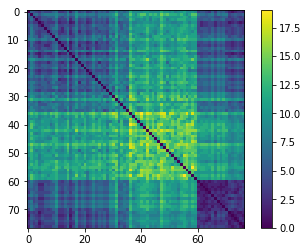

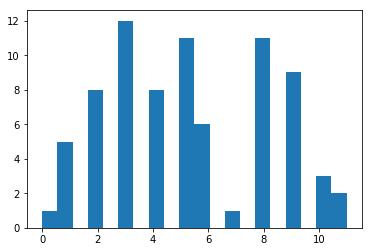

Min dist to avGFP: 0.0


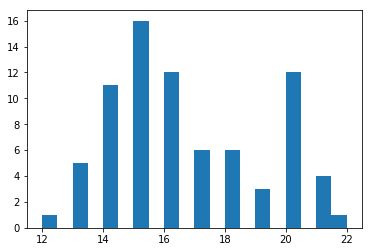

Min dist to sfGFP: 12.0


In [17]:
plt.imshow(pw_ld)
plt.colorbar()
plt.show()

plt.hist(av_ld[:,0],bins=20)
plt.show()
print('Min dist to avGFP:', np.min(av_ld[:,0]))


plt.hist(av_ld[:,1],bins=20)
plt.show()
print('Min dist to sfGFP:', np.min(av_ld[:,1]))

What about distances to all other test parents? (from A049m in mlpe-gfp-pilot):

In [18]:
test_parents = ['GFPhal', 'muGFP', 'hfriFP', 'TagGFP2', 'GFPxm191uv',
'Superfolder_GFP', 'Folding_Reporter_GFP', 'Ypet', 'TagYFP',
'Clover', 'mClover3', 'Citrine', 'mEmerald', 'mVenus',
'J8VIQ3_9SPHN', 'sfGFP_internal']

parent_names, parent_seqs = A009_common.fasta_read(
    './20181110_filtered_FPBase_Aequorea_FPs_candidates_for_synthesis_alignment.fasta')

test_parent_names = []
test_parent_seqs = []
for i in range(len(parent_names)):
    if parent_names[i] in test_parents:
        test_parent_names.append(parent_names[i])
        test_parent_seqs.append(parent_seqs[i])


In [19]:
assert set(test_parent_names) == set(test_parents)

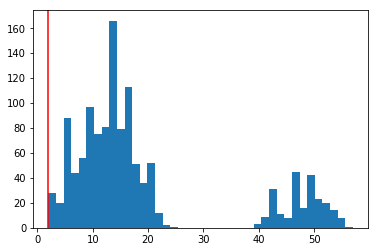

2.0


In [20]:
ld_test = utils.levenshtein_distance_matrix(list(simple_final_df['lib_consistent_seq']), test_parent_seqs)

plt.hist(ld_test.reshape(-1), bins=40)
plt.axvline(np.min(ld_test), color='r')
plt.show()

print(np.min(ld_test))

In [21]:
utils.levenshtein_distance_matrix([constants.AVGFP_AA_SEQ], test_parent_seqs)

array([[ 6., 14.,  4., 50., 41., 11.,  5., 12., 47., 12., 15.,  7.,  7.,
        10.,  4., 14.]])

Great so, all of the designs are at least 2 mutations away from the test parents. So we're not simply copying them. 

## Generate reverse translations of the amino acid sequences.

In [22]:
simple_final_df['lib_consistent_nt_seq'] = simple_final_df['lib_consistent_seq'].apply(
    lambda x: utils.aa_to_dna(constants.AVGFP_AA_SEQ, constants.AVGFP_NT_SEQ, x))

simple_final_df.head()

,id,seq,annotation,lib_consistent_seq,lib_consistent_nt_seq
33,GFP_SimAnneal-ET_Random_Init_1-0024-02-1d0c486...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...,ATGAGTAAAGGCGAAGAGCTGTTCACTGGTGTAGTCCCGATTCTGG...
28,GFP_SimAnneal-ET_Global_Init_1-0096-02-341cf5c...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,ATGAGTAAAGGCGAAGAGCTGTTCACTGGTGTAGTCCCGATTCTGG...
24,GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,ATGAGTAAAGGCGAAGAGCTGTTCACTGGTGTAGTCCCGATTCTGG...
15,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,ATGAGTAAAGGCGAAGAGCTGTTCACTGGTGTAGTCCCGATTCTGG...
21,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,ATGAGTAAAGGCGAAGAGCTGTTCACTGGTGTAGTCCCGATTCTGG...


Some quick checks

In [23]:
for i,r in simple_final_df.iterrows():
    # Check translation of reverse translation is correct.
    assert r['lib_consistent_seq'] == translate(r['lib_consistent_nt_seq'])
    
    # Check left arm of seq is WT
    assert r['lib_consistent_nt_seq'][:A006_common.GFP_LIB_REGION[0]*3] == constants.AVGFP_NT_SEQ[:A006_common.GFP_LIB_REGION[0]*3]
    
    # Check right arm of seq is WT
    assert r['lib_consistent_nt_seq'][A006_common.GFP_LIB_REGION[1]*3:] == constants.AVGFP_NT_SEQ[A006_common.GFP_LIB_REGION[1]*3:]
    
    # Check center of seq is NOT WT
    assert (translate(r['lib_consistent_nt_seq'][A006_common.GFP_LIB_REGION[0]*3:A006_common.GFP_LIB_REGION[1]*3]) 
            != constants.AVGFP_AA_SEQ[A006_common.GFP_LIB_REGION[0]*3:A006_common.GFP_LIB_REGION[1]*3])

In [24]:
NT_LIB_LEFT = A006_common.GFP_LIB_REGION[0]*3
NT_LIB_RIGHT = A006_common.GFP_LIB_REGION[1]*3

print('WT NT region:', (constants.AVGFP_NT_SEQ[NT_LIB_LEFT:NT_LIB_RIGHT]))
print('WT AA region:', translate(constants.AVGFP_NT_SEQ[NT_LIB_LEFT:NT_LIB_RIGHT]))

WT NT region: AGCGGCGAGGGTGAAGGTGACGCAACTTATGGTAAACTGACGCTGAAGTTCATCTGTACTACTGGTAAACTGCCGGTACCTTGGCCGACTCTGGTAACGACGCTGAGCTATGGTGTTCAGTGCTTTAGCCGTTATCCGGACCACATGAAGCAGCATGACTTCTTCAAGTCCGCCATGCCGGAAGGCTATGTGCAGGAACGCACGATTTTTTTTAAGGATGACGGCAATTACAAAACGCGTGCG
WT AA region: SGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRA


In [25]:
# Define Gibson homology arms. These are the vector primers I'll use.
LEFT_HOMOLOGY_ARM = 'CAACGGTCATAAGTTTTCCGTG' # 22bp
RIGHT_HOMOLOGY_ARM = 'GAAGTGAAATTTGAAGGCGATAC' # 23bp

PAD_SEQUENCE = 'AGTCTCGACGAT' # Otherwise our genes will be too short



In [26]:
simple_final_df['dna_to_order'] = simple_final_df['lib_consistent_nt_seq'].apply(lambda x: 
    LEFT_HOMOLOGY_ARM + x[NT_LIB_LEFT:NT_LIB_RIGHT] + RIGHT_HOMOLOGY_ARM + PAD_SEQUENCE
)


# Add simple order ID. Original IDs are too long for Twist's software system
simple_final_df['order_id'] = ['gene_%d'%i for i in range(simple_final_df.shape[0])]


print(len(simple_final_df['dna_to_order'].iloc[0]))

simple_final_df.head()

300


,id,seq,annotation,lib_consistent_seq,lib_consistent_nt_seq,dna_to_order,order_id
33,GFP_SimAnneal-ET_Random_Init_1-0024-02-1d0c486...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...,ATGAGTAAAGGCGAAGAGCTGTTCACTGGTGTAGTCCCGATTCTGG...,CAACGGTCATAAGTTTTCCGTGAGCGGCGAGGGTGAAGGTGACGCA...,gene_0
28,GFP_SimAnneal-ET_Global_Init_1-0096-02-341cf5c...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,ATGAGTAAAGGCGAAGAGCTGTTCACTGGTGTAGTCCCGATTCTGG...,CAACGGTCATAAGTTTTCCGTGAGCGGCGAGGGTGAAGGTGACGCA...,gene_1
24,GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,ATGAGTAAAGGCGAAGAGCTGTTCACTGGTGTAGTCCCGATTCTGG...,CAACGGTCATAAGTTTTCCGTGAGCGGCGAGGGTGAAGGTGACGCA...,gene_2
15,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,ATGAGTAAAGGCGAAGAGCTGTTCACTGGTGTAGTCCCGATTCTGG...,CAACGGTCATAAGTTTTCCGTGAGCGGCGAGGGTGAAGGTGACGCA...,gene_3
21,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,highly functional,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,ATGAGTAAAGGCGAAGAGCTGTTCACTGGTGTAGTCCCGATTCTGG...,CAACGGTCATAAGTTTTCCGTGAGCGGCGAGGGTGAAGGTGACGCA...,gene_4


In [27]:
print('Estimated cost: $' + str(len(simple_final_df['dna_to_order'].iloc[0])*simple_final_df.shape[0]*0.07))


Estimated cost: $1617.0000000000002


## Export

In [28]:
print(simple_final_df.shape)

(77, 7)


In [29]:
simple_final_df.to_csv('A009c_GFP_aggregated_unirep_designs_ASR_consensus_seqs.csv', index=False)
simple_final_df[['order_id', 'dna_to_order']].to_csv('A009c_twist_order.csv', index=False)